In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv('aapl.csv')
df2 = pd.read_csv('msft.csv')
df3 = pd.read_csv('ibm.csv')

df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.519279,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.586557,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.726296,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.859330,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.838936,394024400


In [4]:
from collections import deque
import random

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size, epsilon, epsilon_decay):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.initial_trend = trend
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay

        tf.compat.v1.reset_default_graph()
        tf.compat.v1.disable_eager_execution()
        self.sess = tf.compat.v1.InteractiveSession()
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size])
        feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(1e-5).minimize(self.cost)
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.loss_values = {}
        self.portfolio_values = {}
   
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: bought 1 unit at price %f, total balance is %f'% (t, self.trend[t], initial_money))
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sold 1 unit at price %f, investment %f %%, total balance is %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                self.portfolio_values[i + 1] =  starting_money + len(inventory) * self.initial_trend[-1]
                self.loss_values[i+1] = cost
                print('epoch: %d, loss: %f, portfolio value: %f'%(i + 1, cost, starting_money + len(inventory) * self.initial_trend[-1]))
        

Now we will conduct an ablation study of different values for epsilon decay to determine the optimal value for this hyperparameter that maximizes the tradeoff between exploration and exploitation. The values we will use 

In [5]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent001 = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
              epsilon = 1.0,
              epsilon_decay = .999)
agent001.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

<ipython-input-4-32829124c9b5>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-4-32829124c9b5>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, loss: 0.256847, portfolio value: 10179.201139
epoch: 20, loss: 0.203931, portfolio value: 10209.910789
epoch: 30, loss: 0.205722, portfolio value: 10166.745796
epoch: 40, loss: 0.183302, portfolio value: 10190.716491
epoch: 50, loss: 0.166434, portfolio value: 10172.719686
epoch: 60, loss: 0.151781, portfolio value: 10186.641832
epoch: 70, loss: 0.139635, portfolio value: 10202.780771
epoch: 80, loss: 0.129462, portfolio value: 10199.260061
epoch: 90, loss: 0.113959, portfolio value: 10245.082202
epoch: 100, loss: 0.106609, portfolio value: 10217.580414
epoch: 110, loss: 0.099942, portfolio value: 10220.378633
epoch: 120, loss: 0.097085, portfolio value: 10273.031142
epoch: 130, loss: 0.089799, portfolio value: 10273.860417
epoch: 140, loss: 0.084306, portfolio value: 10365.459704
epoch: 150, loss: 0.089646, portfolio value: 10249.200061
epoch: 160, loss: 0.076590, portfolio value: 10279.755769
epoch: 170, loss: 0.074015, portfolio value: 10382.174347
epoch: 180, loss: 0.066

In [6]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent002 = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
              epsilon = 1.0,
              epsilon_decay = .996)

agent002.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-4-32829124c9b5>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-4-32829124c9b5>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, loss: 0.315930, portfolio value: 44284.317832
epoch: 20, loss: 0.175351, portfolio value: 26711.108766
epoch: 30, loss: 0.145186, portfolio value: 20958.582319
epoch: 40, loss: 0.128322, portfolio value: 19342.342315
epoch: 50, loss: 0.127710, portfolio value: 19259.499461
epoch: 60, loss: 0.115503, portfolio value: 18231.706592
epoch: 70, loss: 0.105505, portfolio value: 18012.792297
epoch: 80, loss: 0.120071, portfolio value: 18263.516949
epoch: 90, loss: 0.112039, portfolio value: 18199.820870
epoch: 100, loss: 0.100945, portfolio value: 17537.689078
epoch: 110, loss: 0.099484, portfolio value: 17126.023724
epoch: 120, loss: 0.097685, portfolio value: 17917.281236
epoch: 130, loss: 0.106891, portfolio value: 17909.867650
epoch: 140, loss: 0.097951, portfolio value: 17785.938739
epoch: 150, loss: 0.090469, portfolio value: 17558.105525
epoch: 160, loss: 0.091556, portfolio value: 17681.062305
epoch: 170, loss: 0.086041, portfolio value: 17864.907322
epoch: 180, loss: 0.076

In [7]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent003 = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
              epsilon = 1.0,
              epsilon_decay = .993)

agent003.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

<ipython-input-4-32829124c9b5>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-4-32829124c9b5>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, loss: 0.121303, portfolio value: 10183.573604
epoch: 20, loss: 0.116276, portfolio value: 10185.275380
epoch: 30, loss: 0.095799, portfolio value: 10190.305728
epoch: 40, loss: 0.093498, portfolio value: 10225.335374
epoch: 50, loss: 0.091914, portfolio value: 10308.348235
epoch: 60, loss: 0.099162, portfolio value: 10375.966784
epoch: 70, loss: 0.102741, portfolio value: 10426.727179
epoch: 80, loss: 0.090398, portfolio value: 10572.125033
epoch: 90, loss: 0.086595, portfolio value: 10597.093264
epoch: 100, loss: 0.073145, portfolio value: 10860.499694
epoch: 110, loss: 0.080676, portfolio value: 11295.595787
epoch: 120, loss: 0.081418, portfolio value: 15227.202942
epoch: 130, loss: 0.050877, portfolio value: 18329.239755
epoch: 140, loss: 0.048442, portfolio value: 20772.420153
epoch: 150, loss: 0.046485, portfolio value: 20970.439798
epoch: 160, loss: 0.044542, portfolio value: 23250.270887
epoch: 170, loss: 0.087863, portfolio value: 22677.183377
epoch: 180, loss: 0.048

In [8]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent004 = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
              epsilon = 1.0,
              epsilon_decay = .990)

agent004.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

<ipython-input-4-32829124c9b5>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-4-32829124c9b5>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, loss: 0.247682, portfolio value: 21297.725845
epoch: 20, loss: 0.148139, portfolio value: 23860.239802
epoch: 30, loss: 0.142829, portfolio value: 23035.533011
epoch: 40, loss: 0.128907, portfolio value: 24651.334083
epoch: 50, loss: 0.124522, portfolio value: 23652.288727
epoch: 60, loss: 0.109060, portfolio value: 22752.209069
epoch: 70, loss: 0.121817, portfolio value: 23638.196223
epoch: 80, loss: 0.140342, portfolio value: 24526.707652
epoch: 90, loss: 0.088187, portfolio value: 22181.099053
epoch: 100, loss: 0.081302, portfolio value: 23524.301215
epoch: 110, loss: 0.076236, portfolio value: 23855.207303
epoch: 120, loss: 0.071483, portfolio value: 25216.801233
epoch: 130, loss: 0.067211, portfolio value: 24298.758007
epoch: 140, loss: 0.089566, portfolio value: 24539.168718
epoch: 150, loss: 0.060099, portfolio value: 24364.476591
epoch: 160, loss: 0.057222, portfolio value: 25260.165876
epoch: 170, loss: 0.053983, portfolio value: 25609.930892
epoch: 180, loss: 0.051

In [17]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent005 = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
              epsilon = 1.0,
              epsilon_decay = .987)

agent005.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-4-32829124c9b5>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-4-32829124c9b5>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, loss: 0.528232, portfolio value: 24991.885568
epoch: 20, loss: 0.331451, portfolio value: 22993.487340
epoch: 30, loss: 0.241076, portfolio value: 23288.493783
epoch: 40, loss: 0.192137, portfolio value: 24917.175910
epoch: 50, loss: 0.158863, portfolio value: 26612.146296
epoch: 60, loss: 0.132473, portfolio value: 28395.491316
epoch: 70, loss: 0.114284, portfolio value: 28375.181660
epoch: 80, loss: 0.099922, portfolio value: 31107.296657
epoch: 90, loss: 0.089945, portfolio value: 31607.082376
epoch: 100, loss: 0.081566, portfolio value: 31900.300967
epoch: 110, loss: 0.075312, portfolio value: 33429.972751
epoch: 120, loss: 0.069664, portfolio value: 35038.735970
epoch: 130, loss: 0.064881, portfolio value: 35216.095623
epoch: 140, loss: 0.061275, portfolio value: 34622.327408
epoch: 150, loss: 0.072341, portfolio value: 34131.207030
epoch: 160, loss: 0.054826, portfolio value: 35398.204551
epoch: 170, loss: 0.052469, portfolio value: 36207.027408
epoch: 180, loss: 0.050

In [23]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent006 = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
              epsilon = 1.0,
              epsilon_decay = .984)

agent006.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-4-32829124c9b5>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-4-32829124c9b5>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, loss: 0.562243, portfolio value: 25050.586651
epoch: 20, loss: 0.198345, portfolio value: 14918.955102
epoch: 30, loss: 0.172971, portfolio value: 13829.377952
epoch: 40, loss: 0.155585, portfolio value: 13523.481891
epoch: 50, loss: 0.146463, portfolio value: 13130.620829
epoch: 60, loss: 0.125375, portfolio value: 12886.682611
epoch: 70, loss: 0.109914, portfolio value: 12666.234374
epoch: 80, loss: 0.117783, portfolio value: 13010.564748
epoch: 90, loss: 0.128699, portfolio value: 13752.883317
epoch: 100, loss: 0.107170, portfolio value: 15227.457972
epoch: 110, loss: 0.108835, portfolio value: 16313.466560
epoch: 120, loss: 0.099721, portfolio value: 17886.186925
epoch: 130, loss: 0.089772, portfolio value: 18162.672659
epoch: 140, loss: 0.094812, portfolio value: 20049.111599
epoch: 150, loss: 0.077834, portfolio value: 20597.395533
epoch: 160, loss: 0.081064, portfolio value: 22663.496264
epoch: 170, loss: 0.074260, portfolio value: 23636.566621
epoch: 180, loss: 0.075

In [18]:
import pickle

with open('agent001_portfoliovalues.pkl', 'wb') as f:
    pickle.dump(agent001.portfolio_values, f)

with open('agent001_lossvalues.pkl', 'wb') as f:
    pickle.dump(agent001.loss_values, f)

with open('agent002_portfoliovalues.pkl', 'wb') as f:
    pickle.dump(agent002.portfolio_values, f)

with open('agent002_lossvalues.pkl', 'wb') as f:
    pickle.dump(agent002.loss_values, f)

with open('agent003_portfoliovalues.pkl', 'wb') as f:
    pickle.dump(agent003.portfolio_values, f)

with open('agent003_lossvalues.pkl', 'wb') as f:
    pickle.dump(agent003.loss_values, f)

with open('agent004_portfoliovalues.pkl', 'wb') as f:
    pickle.dump(agent004.portfolio_values, f)

with open('agent004_lossvalues.pkl', 'wb') as f:
    pickle.dump(agent004.loss_values, f)

with open('agent005_portfoliovalues.pkl', 'wb') as f:
    pickle.dump(agent005.portfolio_values, f)

with open('agent005_lossvalues.pkl', 'wb') as f:
    pickle.dump(agent005.loss_values, f)

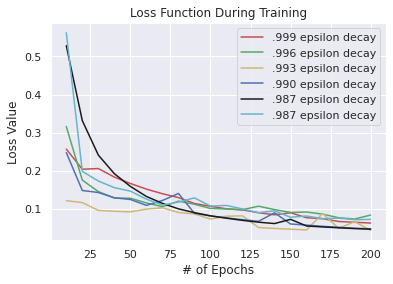

In [26]:
plt.plot(*zip(*sorted(agent001.loss_values.items())), color='r', label='.999 epsilon decay')
plt.plot(*zip(*sorted(agent002.loss_values.items())), color='g', label='.996 epsilon decay')
plt.plot(*zip(*sorted(agent003.loss_values.items())), color='y', label='.993 epsilon decay')
plt.plot(*zip(*sorted(agent004.loss_values.items())), color='b', label='.990 epsilon decay')
plt.plot(*zip(*sorted(agent005.loss_values.items())), color='k', label='.987 epsilon decay')
plt.plot(*zip(*sorted(agent006.loss_values.items())), color='c', label='.987 epsilon decay')
plt.title('Loss Function During Training')
plt.ylabel('Loss Value')
plt.xlabel('# of Epochs')
plt.legend()
plt.show()


In [27]:
def average_portfolio_value(portfolio_values):
  key_sum = 0
  total_sum = 0
  for key, value in portfolio_values.items():
    key_sum += key
    total_sum += value * key
  
  return total_sum / key_sum

Text(0.5, 1.0, 'Hyperparameter Tuning for Epsilon Decay')

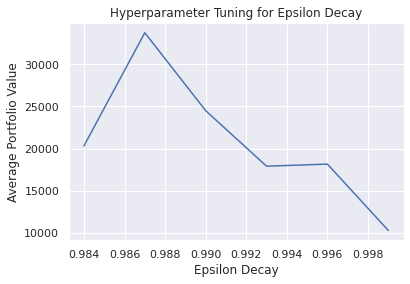

In [28]:
x = [.999, .996, .993, .990, .987, .984]
y = [average_portfolio_value(agent001.portfolio_values), average_portfolio_value(agent002.portfolio_values), average_portfolio_value(agent003.portfolio_values), average_portfolio_value(agent004.portfolio_values), average_portfolio_value(agent005.portfolio_values), average_portfolio_value(agent006.portfolio_values)]
plt.plot(x, y)
plt.xlabel('Epsilon Decay')
plt.ylabel('Average Portfolio Value')
plt.title('Hyperparameter Tuning for Epsilon Decay')

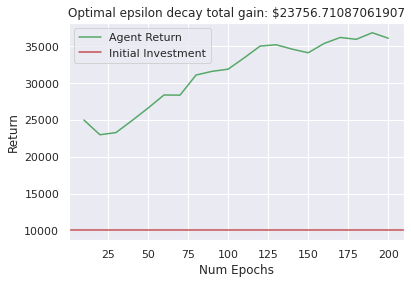

In [47]:
plt.plot(*zip(*sorted(agent005.portfolio_values.items())), color='g', label="Agent Return")
plt.axhline(y=10000, color='r', label='Initial Investment')
total_gain = average_portfolio_value(agent005.portfolio_values) - 10000
plt.title('Optimal epsilon decay total gain: $' + str(total_gain))
plt.xlabel('Num Epochs')
plt.ylabel('Return')
plt.legend()
plt.show()

In [42]:
states_buy, states_sell, total_gains, invest = agent005.buy(initial_money = 10000)


day 17: bought 1 unit at price 15.974286, total balance is 9984.025714
day 21: bought 1 unit at price 16.254286, total balance is 9967.771428
day 23: bought 1 unit at price 16.570356, total balance is 9951.201072
day 25: bought 1 unit at price 17.024286, total balance is 9934.176786
day 26: bought 1 unit at price 17.613214, total balance is 9916.563572
day 27: bought 1 unit at price 17.622143, total balance is 9898.941429
day 30: bought 1 unit at price 17.773930, total balance is 9881.167499
day 31: bought 1 unit at price 17.936071, total balance is 9863.231428
day 33: bought 1 unit at price 18.387501, total balance is 9844.843927
day 37: bought 1 unit at price 18.777143, total balance is 9826.066784
day 38: bought 1 unit at price 19.121786, total balance is 9806.944998
day 39: bought 1 unit at price 19.372856, total balance is 9787.572142
day 41: bought 1 unit at price 19.470715, total balance is 9768.101427
day 43, sold 1 unit at price 18.937857, investment 18.552134 %, total balance

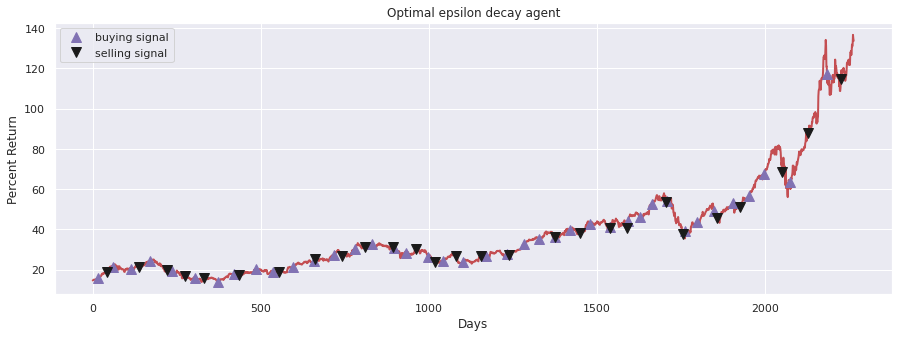

In [46]:
fig = plt.figure(figsize = (15,5))
splice_states_buy = []
for i in range(len(states_buy)):
  if i % 20 == 0:
    splice_states_buy.append(states_buy[i])

splice_states_sell = []
for i in range(len(states_sell)):
  if i % 20 == 0:
    splice_states_sell.append(states_sell[i])

plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = splice_states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = splice_states_sell)
plt.title("Optimal epsilon decay agent")
plt.xlabel('Days')
plt.ylabel("Percent Return")
plt.legend()
plt.show()